In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8) # set default figure size, 8in by 6in

# Assignment 05: K-Means and PCA

**Due Date:** Friday 12/10/2021 (by midnight)


## Introduction 
In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image.  In the second part, you
will use principal component analysis to visualize the resulting principal component vectors found for some data, and see how such
data are projected onto the principal components.  

# 1 K-means Clustering

In the first part of this exercise, you will implement the K-means algorithm and use it to visualize and example of how
K-means clustering functions in practice.  We will be using an example 2D dataset that will help you gain an intiution of how
the K-means algorithm works.  First of all, here is the data, and the initial set of centroids we will be working with.

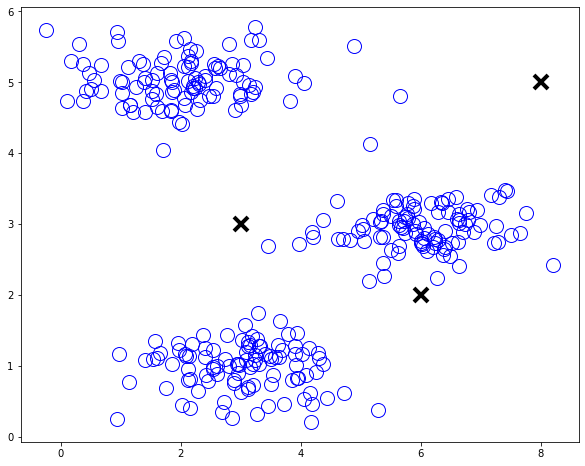

In [2]:
data = pd.read_csv('../data/assg-05-data-kmeans.csv', names=['x1', 'x2'])
X = data[['x1', 'x2']].values
m,n = X.shape # m = number of training examples, n = number of features

initial_centroids = np.array([[3.0, 3.0],
                              [6.0, 2.0],
                              [8.0, 5.0]])

plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=14, fillstyle='none')
plt.plot(initial_centroids[:, 0], initial_centroids[:, 1], 'kx', markersize=14, markeredgewidth=4);

## 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together.  Concretely, you are given a training
set `X` $\{ x^{(1)}, x^{(2)}, \ldots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ is $n$ dimensional), and want to group the
data into a few cohesive "clusters".  The intuition behind K-means is an iterative procedure that starts by guessing the
initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and the recomputing
the centroids based on the assignment.

In Python pseudo-code, the K-means algorithm is as follows:
```python
# Initialize centroids
centroids = kmeans_init_centroids(X, K)

# iterate procedure to move centroids incrementally
for iter = range(iterations): # or iterate until we detect convergence
   # Cluster assignment step: Assign each data point to the
   # closest centroid.  c[i] corresponds to the c^(i), the index of the
   # centroid assigned to example i
   c = find_closest_centroids(X, centroids)
   
   # Move centroid step: Compute means based on centroid assignments
   centroids = compute_centroids(X, c, K)
```

The innter-loop of the algorithm repeatedly carries out two steps: (i) Assigning each training example $x^{(i)}$ to its closest
centroid, and (ii) Recomputing the mean of each centroid using the points assigned to it.  The K-means algorithm will always
converge to some final set of means for the centroids.  Note that the converted solutions may not always be ideal and depends on
the initial setting of the centroids.  Therefore, in practice, the K-means algorithm is usually run a few times with different
random initializations.  One way to choose between these different solutions from different random initializations is to choose
the one with the lowest cost function value (distortion).

In this exercise you will implement the two phases of the K-means algorithm separately as functions with the names
`find_closest_centroids()` and `compute_centroids()`.

## 1.2 Finding Closest Centroids

In the "cluster assignemnt" phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its
closest centroid, given the current positions of centroids.  Specifically, for every example $i$ we set

$$
c^{(i)} := j \;\; \text{that minimizes} \;\; \| x^{(i)} - \mu_j \|^2
$$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j$'th
centroid.

In the next cell, complete the code for the `find_closest_centroids()` function.  This function takes the data matrix `X`
and the locations of the `centroids` as input parameters.  It should output a one-dimensional array `c` that holds the
index (a value in $\{1, \cdots, K\}$, where $K$ is the total number of centroids) of the closest centroid to every
training example.

You can implement this using a loop over every training example and every centroid.  Once you have completed the function, you
should see the following centroid assignments for the first 5 data points from our input data:

```python
# test the function, the indexes of the closest centroids to the first 5 data points should be [0 2 1 0 0]
c = find_closest_centroids(X, initial_centroids)
print c[:5]
>>> [0 2 1 0 0]
```

In [3]:
def find_closest_centroids(X, centroids):
    '''This function computes the centroid memberships for every example input data in X.  It returns
    the closest centroids c^(i) for the dataset X, where each value in c is the index of the centroid
    that each input data item was assigned to.
    '''
    
    # some useful variables
    K = centroids.shape[0]
    m, n = X.shape
    
    # you need to return the following variable filled in correctly
    c = np.empty(m, dtype=int)
    
    # Instructions: Go over every example in the input data X, and store the index inside of the array c to be returned.
    # Concretely, c[i] should contain the index of the centroid closest to example i.  Hence, it should be a value in the
    # range 1..K.
    # If it is easiest to understand, you might want to use an inner for loop that iterates over each of the j centroids
    # computing the squared distance (using np.linalg.norm).  In this loop you want to look for the minimum distance to a
    # centroid, and set the c[i] equal to the index j of this closest centroid
                
    # The result should be calculated and returned in the c variable
    return c

In [4]:
# test the function, the indexes of the closest centroids to the first 5 data points should be [0 2 1 0 0]
c = find_closest_centroids(X, initial_centroids)
print(c[:5])

[140070846886304 140070846886304  93852308468528  93852308468528
 140069788422360]


## 1.3 Computing Centroid Means

Given assignments of every point to a centroid (calculated by the `find_closest_centroids()` function you just wrote), the
second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it.  Specifically, for
every centroid $k$ we set

$$
\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
$$

where $C_k$ is the set of example input data that are assigned to centroid $k$ and $| C_k |$ is the number of items that were
thus assigned.  Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then $| C_k | = 2$
and you should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)})$

You should now complete the code for the `compute_centroids()` function.  You can implement this function using a loop over the
centroids.  You can also use a loop over the examples, but for this function there is a fairly straight forward way to vectorice
much of the code (but either an iterative or vectorized solution is fine).

Once you have completed the function, you should get the following results for computing the new centroids given our data and
initial set of centroids:

```python
# test your implementation.
K = initial_centroids.shape[0]
c = find_closest_centroids(X, initial_centroids)
centroids = compute_centroids(X, c, K)
print centroids
>>> 
[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]
```

In [5]:
def compute_centroids(X, c, K):
    '''Return the new centroids by computing the means of the data points assigned to each centroid.  We are
    given X the input data points, and the vector c, which is a vector of indexes indicating which centroid each
    data point in X has been assigned too.  The variable K is a regular scalar value, indicating the total number
    of centroids K we are computing.  This function should return a new Kxn sized array of computed centroids.
    '''
    
    # some useful variables
    m, n = X.shape
    
    # you need to return the following variable filled in correctly with the new centroids
    centroids = np.zeros( (K, n) )

    # Instructions: Go over every centroid and compute the mean of all points
    # that belong to it.  Concretely, the row vector centroids[j, :] should contain the mean
    # of the data points in X assigned to centroid j.
    # NOTE: you can use a for-loop over the centroids, and an inner loop over the X input data to compute this, though
    # vectorized implementations, especially of the inner loop, are possible.
        
    # the resulting new centroids should be calculated and returned in the centroids variable
    return centroids

In [6]:
# test your implementation.
K = initial_centroids.shape[0]
c = find_closest_centroids(X, initial_centroids)
centroids = compute_centroids(X, c, K)
print(centroids)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


## 1.4 K-means on example dataset

After you have completed the two function, in the next cell we will use them to run the K-means algorithm on our example data with
the given initial centroids, and visualize the results, to help you understand how K-means works.  Your functions are called in
the cell below, so they need to be working correctly in order to see the correct results.  Notice that the code calls your two
functions in a loop that is hardcoded to execute 10 times.  In a real implementation of K-means, we would normally test the previous
and new set of calculated centroids to see if any have changed between two iterations, and we keep on iterating as long as the
centroids are still changing.



In [7]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
from IPython import display

def visualize_kmeans_iteration(centroids_history, c, K, X, num_itr):
    '''Visualize iterations of K-means clustering.  We are given a history of
    centroids positions, the current centroid assignments for the input data,
    the input data, and the iteration number.  This function
    plots the data, coloring it according to the centroid assignments, then plots the 
    history of the centroid locations.
    '''
    # some iPython internals, so that we create only 1 figure and dynamically update it...
    display.clear_output()
    display.display(plt.gcf())    
    
    # set up a color mapping, so can color an arbitrary number of K centroid points different colors
    values = list(range(K))
    jet = cm = plt.get_cmap('jet') 
    c_norm  = colors.Normalize(vmin=0, vmax=values[-1])
    c_map = cmx.ScalarMappable(norm=c_norm, cmap=jet)
    
    # plot points in centroid k, color coded 
    for k in range(K):
        points = X[c==k, :]
        plt.plot(points[:, 0], points[:, 1], 'o', markersize=14, fillstyle='none', markeredgecolor=c_map.to_rgba(k))
    
    # now plot the history of the calculated centroids
    for itr in range(num_itr+1):
        centroids = centroids_history[itr, :, :]
        plt.plot(centroids[:, 0], centroids[:, 1], 'kx', markersize=14, markeredgewidth=4) 
        
        # draw line connecting successive centroid locations
        if itr > 0: 
            prev_centroids = centroids_history[itr-1, :, :]
            for k in range(K):
                centroid = centroids[k, :]
                prev_centroid = prev_centroids[k, :]
                plt.plot([centroid[0], prev_centroid[0]], [centroid[1], prev_centroid[1]], 'k-')
                
    # add titles and labels
    plt.title('Iteration Number: %d' % num_itr)

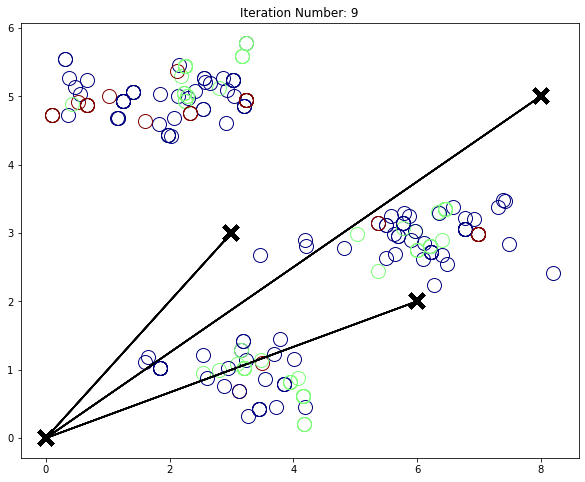

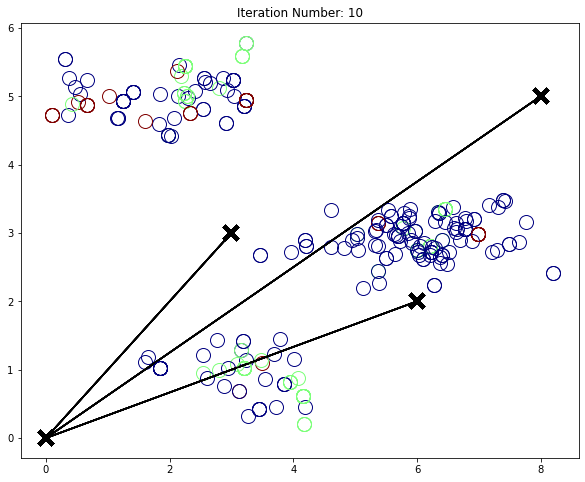

In [8]:
import time

# some useful variables
m, n = X. shape
K = initial_centroids.shape[0]
num_iterations = 10

# plot initial set of centroids and set up to iterate the K-means clustering algorithm
plt.figure() # we create 1 figure, the function clears it and redraws it for us multiple times
centroids = initial_centroids
centroids_history = np.empty( (num_iterations+1, K, n) ) # to hold history of centroids
centroids_history[0, :, :] = centroids
c = find_closest_centroids(X, centroids)
visualize_kmeans_iteration(centroids_history, c, K, X, 0)

# iterate the K-means clustering algorithm
for iter in range(1, num_iterations+1): 
    c = find_closest_centroids(X, centroids)
    centroids = compute_centroids(X, c, K)
    
    centroids_history[iter, :, :] = centroids
    visualize_kmeans_iteration(centroids_history, c, K, X, iter)
    
    # pause a bit,
    #time.sleep(1)
    
    # or you can instead pause until you press a key
    #input('Press <Enter> for next iteration')

# 2 Principal Component Analysis

In this part of the exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.   You will use
a small example 2D dataset to get an intuition on how PCA works.

## 2.1 Example Dataset

To help you understand how PCA works, you will use the following 2D dataset in the code for this part of the exercise.  This dataset
has one direction of large variation and one of smaller variation.  Here we load the data and plot it for you.

In [9]:
data = pd.read_csv('../data/assg-05-data-pca.csv', names=['x1', 'x2'])
X = data[['x1', 'x2']].values
m,n = X.shape # m = number of training examples, n = number of features

(0.9436799437644379, 6.1478517074830386, 2.6544689674327113, 7.587421750017763)

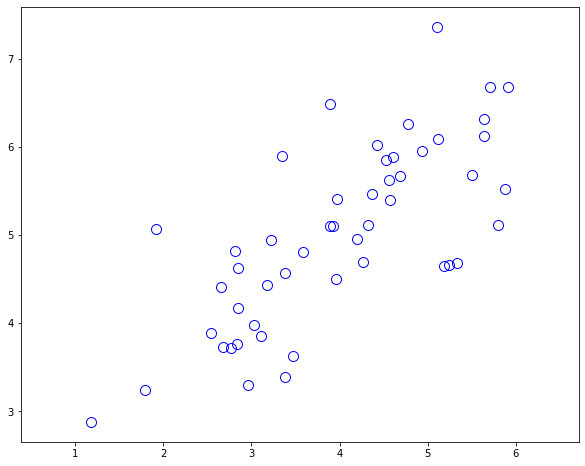

In [10]:
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=10, fillstyle='none')
plt.axis('equal')

## 2.2 Implementing PCA

In this part of the exercise, you will implement PCA.  PCA consists of two computational steps: First, you compute the 
covariance matrix of the data.  Then you use the `numpy` `svd` function from the linear algebra routines to compute the
eigenvectors $U_1, U_2, \cdots, U_n$.  These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtraction the mean value of each feature from the dataset,
and scaling each dimension (by their standard deviation) so that they are in the same range.  In the following cell, implemnt
the function named `feature_normalize()` to take an array X of input data, and return a new array where all features have
been mean normalized and scaled by the standard devaition.  If your function is working correctly, you should get the following
results for the first 5 data points from our example input data:

```python
X_norm, mu, sigma = feature_normalize(X)

print mu
>>> [ 3.98926528  5.00280585]

print sigma
>>> [ 1.16126017  1.01312201]

print X_norm[:5, :]
>>> 
[[-0.52331306 -1.59279252]
 [ 0.46381518  0.84034523]
 [-1.14839331 -0.58315891]
 [-1.05405373 -1.27071783]
 [-0.98402167 -0.81658417]]
```

In [11]:
def feature_normalize(X):
    '''Given a matrix of size m x n (m data points, with n features for each data point), perform
    both mean normalization and feature scaling on all of the features for all of the m data points.
    This function returns the normalized X data, and it also returns the original mean and standard deviations
    found for each feature.
    '''
    
    # some useful variables
    m, n = X.shape
    
    # The following variable should hold the mean normalized and feature scaled data and be returned from this
    # function
    X_norm = np.empty( (m, n) )
    
    # Create a variable named mu that will be a numpy array.  mu should contain the mean value for each column/feature
    # of the data in the X input data array.  This means mu should be a simple vector of size n, the means for the n 
    # features of our data
    mu = np.empty(n)
    
    # Create a variable named sigma that will hold the standard deviations for each column/feature of the
    # data in the X input array.
    sigma = np.empty(n)
    
    # Instructions: You should have computed your mu and sigma values for the X input data features above.
    # Now simply subtract the means and divde by the standard deviations to perform the normalization and scaling
    # of the data.  Save the normalized data in the X_norm array to be returned.
    
    # Return the resulting normalized data, along with the feature means and feature standard deviations
    # that were used in performing the feature normalization and scaling
    return (X_norm, mu, sigma)

In [12]:
X_norm, mu, sigma = feature_normalize(X)
print(mu)
print(sigma)
print(X_norm[:5, :])

[inf inf]
[inf inf]
[[354.52415299 136.76483233]
 [455.58096317 354.08044338]
 [290.53184346 226.94022178]
 [300.18981631 165.53092231]
 [307.35931608 206.09185317]]


After normalizing teh data, you can implement and run PCA to compute the principal components.  In the following cell we have
created a function simply named `pca()` that takes a (normalized) array of data as its only input.  Your task is to complete
the function to compute the principal components of the dataset.  

First you should compute the covariance matrix of the data, which is given by

$$
\Sigma = \frac{1}{m} X^T X
$$

where $X$ is the data matrix with examples in rows, and $m$ is the number of examples.  Note that $\Sigma$ should be a
$n \times n$ matrix (it is not the summation operator above, it is a simple variable name).

After computing the covariance matrix, you can run SVD on it to compute the principal components.  You can find an implementation
of the SVD singular value decomposition in Python's `numpy.linalg` library, and it will return the matrics `[U, S, V]` where
matrix `U` will contain the principal components we need and S will contain a diagonal matrix which holds information about the
amount of variance represented by each found principal component.

Once you have completed the `pca()` function and run it on our dataset, you should expect that the first principal component
is a vector [-0.707, -0.707] and you should get the following results:

```python
U, S = pca(X_norm)
print U
>>>
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

print S
>>>
[ 1.73553038  0.26446962]
```

In [13]:
def pca(X):
    '''This function expectes a normalized and scaled set of input data points.  This function performs the
    principal component analysis (PCA) algorithm on the data.  It returns the calculated principal component vectors
    U, as well as the array of variances S explained by each principal component.
    '''
    
    # some useful variables
    m, n = X.shape
    
    # First, compute the covariance matrix of the data.  You can do this using iterative loops, or using the simple
    # matrix multiplications equations we gave above.  Save the results of this calculation in the variable name 
    # Sigma
    Sigma = np.empty( (n, n) )
    
    # Next perform singular value decomposition on the computed covariance matrix.  You should use the
    # function from the numpy linalg library.  This function will return the U, S, V matrices from the 
    # decomposition.
    U = S = np.zeros( (n, n) )
    
    # return the U matrix of the principal components, and the S vector of the variance measures
    return U, S

In [14]:
# test the pca function
U, S = pca(X_norm)
print(U)
print(S)

[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]


To understand what the U vectors of principal components represent, it helps to plot them on our original data.  Each column of U
represents a vector.  Likewise each value of the S array represents the amount of variation that that principal component
vector explains or represents.  If we draw our two resulting vectors at the mean location of our data, and scale them by
the amount of variation given by S, we can see what principal component directions were discovered.  For example, lets replot our
data, then plot the U principal component vectors as I just described:

[inf inf]
[0. 0.]
[0. 0.]


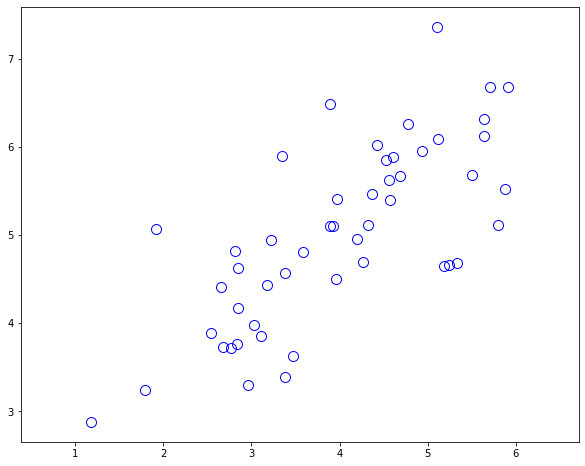

In [15]:
# plot the raw data again
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=10, fillstyle='none')
plt.axis('equal')
ax = plt.gca()

# plot principal component 1.  u1 is a vector, we will plot this vector from the mu means of our data
u1 = U[:, 0]
print(mu)
print(u1)
p1 = mu
v = u1 * 1.5 * S[0] # multiplying by S has effect of scaling this component by the magnitude of variance
ax.arrow(mu[0], mu[1], v[0], v[1], head_width=0.05, head_length=0.1)

# plot principal component 2.  u2 is a vector, we will plot this vector from the mu means of our data
u2 = U[:, 1]
print(u1)
p1 = mu
v = u2 * 1.5 * S[1] # multiplying by S has effect of scaling this component by the magnitude of variance
ax.arrow(mu[0], mu[1], v[0], v[1], head_width=0.05, head_length=0.1)

In the previous figure, we have used the `U` principal components as vectors, and we have drawn representations of these vectors
originating from the mean location for each feature of our original data.  We have scaled the length we drew each vector by
the value given in S, in order to represent the magnitude of variation represented by each of the principal component directions
that were discovered.

# 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each
example onto a lower dimensional space $x^{(i)} \rightarrow z^{(i)}$  (e.g., projecting the data from 2D to 1D).  In this part
of the exercise, you will use the eigenvectors returned by PCA and project the example dataset onto a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the
projected data instead of the original data.  By using the projected data, you can train your model faster as there are less
dimensions in the input.

In the following cell, we will write another function named `project_data()` to perform the dimensionality reduction.
Specifically, you are given a dataset `X`, the principal components `U`, and the desired number of dimensions to reduce
to `K`.  You should project each example in `X` onto the top `K` components in `U`.  In Python, the top `K` components in
`U` are given by the first `K` columns of `U`:


In [16]:
print(U.shape)
print(U)

K = 1
U_reduce =  U[:, :K]
print(U_reduce)

(2, 2)
[[0. 0.]
 [0. 0.]]
[[0.]
 [0.]]


Complete the `project_data()` function in the next cell.  You should find the following result if your projection is working
correctly.  The original 2D data in X_norm will be projected onto 1D.  The first 5 values show the position of the projected
points for each of the original input data projected onto the u1 eigenvector:

```python
Z = project_data(X_norm, U, K)
print Z[:5, :]
>>>
[[ 1.49631261]
 [-0.92218067]
 [ 1.22439232]
 [ 1.64386173]
 [ 1.2732206 ]]
```

In [17]:
def project_data(X, U, K):
    '''Computes the reduced data representation by projecting X onto the top K principal components defined
    by the eigenvectors in U.  If X is an m x n matrix of input data, this will return the project matrix Z
    which will be reduced to m x K, where K < n the number of original features
    '''
    
    # some useful variables
    m, n = X.shape
    U_reduce = U[:, :K]
    
    # the following variable should hold the computed reduction of the original n dimensional data into K dimensions
    Z = np.empty( (m, K) )
    
    # Instructions: Compute the projection of the data using only the top K eigenvectors in U (first K columns,
    #    which should be saved in the U_reduce matrix).  The easiest way to do this is to compute the reduction
    #    for each example input X[i, :], and iterate over all i inputs.  For the i-th example X[i, :], the
    #     projection onto k-dimension is given as 
    #        x = X[i, :]
    #       projection_x = x * U_reduce
        
    # You should return the resulting reduction you calculated in the Z array
    return Z

In [18]:
K = 1
Z = project_data(X_norm, U, K)
print(Z[:5, :])

[[3.38911268]
 [5.8541781 ]
 [4.41199472]
 [3.71541365]
 [4.17550645]]


After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto
the original high dimensional space.  The task of the next function is to project each example `Z` back onto the original
space and return the recovered approximation `X_rec`.

Complete the `recover_data()` function in the next cell.  Once it is working, you should see the following values for the first
5 recovered example data points:

```python
X_rec = recover_data(Z, U, K)
print X_rec[:5, :]
>>>
[[-1.05805279 -1.05805279]
 [ 0.65208021  0.65208021]
 [-0.86577611 -0.86577611]
 [-1.16238578 -1.16238578]
 [-0.90030292 -0.90030292]]
```

In [19]:
def recover_data(Z, U, K):
    '''Recovers an approximation of the original data when using the projected data.  We are given the projection Z
    and the principal component vectors U.  We return the approximate recovered/projected position in the original
    space for the data
    '''

    # some useful variables
    m = Z.shape[0]
    n = U.shape[0]
    U_reduce = U[:, :K]
    
    # the following variable should hold the computed recovery/estimate of the original 
    # n dimensional data recovered from the K dimensional reduction
    X_rec = np.empty( (m, n) )
 
    # Instructions: Compute the approximation of the data by projecting back onto the original space
    #   using the top K eigenvectors in U.  For the i-th example Z[i, :] the approximate recovered
    #   data for dimension j is given as follows
    #     v = Z[i, :]
    #     recovered_x = v * U_reduce
        
    # You should return the resulting recovered project you calculated in the X_rec matrix
    return X_rec

In [20]:
X_rec = recover_data(Z, U, K)
print(X_rec[:5, :])

[[354.52415299 136.76483233]
 [455.58096317 354.08044338]
 [290.53184346 226.94022178]
 [300.18981631 165.53092231]
 [307.35931608 206.09185317]]


Assuming your function to project the data onto K dimensions given U is correct, we can visualize the resulting projection.  In 
the next cell draw the original points in blue, and the calculated projection in red, and connect up each projection.  You should
observe that each point is being projected onto the first $U_1$ principal component we calculated previously.

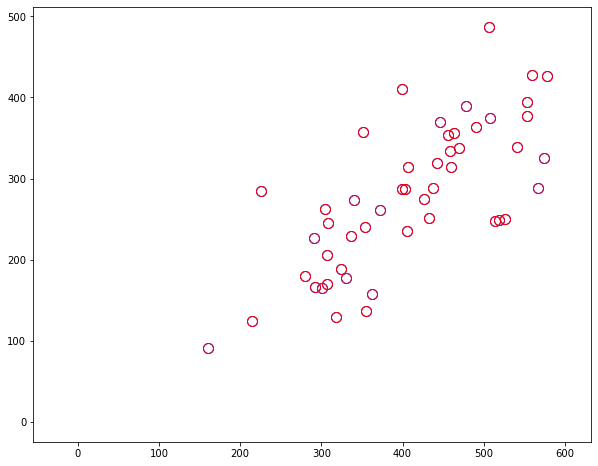

In [21]:
# plot the raw data again, we are displaying the raw data after normalization now, because the projected data 
# will be back into this normalized space
plt.figure()
plt.plot(X_norm[:, 0], X_norm[:, 1], 'bo', markersize=10, fillstyle='none')
plt.axis('equal')
ax = plt.gca()

# plot principal component 1.  u1 is a vector, we will plot this vector from the mu means of our data
v = u1 * 2.0 * S[0] # multiplying by S has effect of scaling this component by the magnitude of variance
plt.plot([ 0,  v[0] ], [ 0,  v[1] ], 'k-', alpha=0.25)
plt.plot([ 0, -v[0] ], [ 0, -v[1] ], 'k-', alpha=0.25)

# plot the recovered data as red circles
plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro', markersize=10, fillstyle='none')

# connect each original point with the recovered/projected point
for i in range(m):
    p_norm = X_norm[i, :]
    p_rec = X_rec[i, :]
    plt.plot([p_norm[0], p_rec[0]], [p_norm[1], p_rec[1]], 'k--', alpha=0.5)